<a href="https://colab.research.google.com/github/GVSU-CIS635/projects-team-1-1/blob/main/Copy_of_Project_Randomforest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Section 1: Data Preparation**

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import StandardScaler
from scipy.stats import chi2_contingency

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes  import GaussianNB
from sklearn.ensemble     import RandomForestClassifier
from xgboost              import XGBClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate, GridSearchCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, classification_report,
    confusion_matrix, precision_recall_curve
)
import warnings
import time
warnings.filterwarnings('ignore')



from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, precision_score, recall_score, f1_score

In [29]:
# Data Loading
# (45211, 17)
df_train = pd.read_csv("https://raw.githubusercontent.com/GVSU-CIS635/projects-team-1-1/main/data/train.csv", sep=";")
df_test = pd.read_csv("https://raw.githubusercontent.com/GVSU-CIS635/projects-team-1-1/main/data/test.csv", sep=";")

In [35]:
print(f"\n Raw data loaded:")
print(f"   Train shape: {df_train.shape}")
print(f"   Test shape: {df_test.shape}")

# Clean column names
df_train.columns = df_train.columns.str.strip()
df_test.columns = df_test.columns.str.strip()

print(f"\n Inspecting columns...")
print(f"   Train columns: {list(df_train.columns)}")
print(f"   Test columns: {list(df_test.columns)}")

# Check if 'y' column exists
if 'y' not in df_train.columns:
    print("\n ERROR: 'y' column not found in training data!")
    print(f"   Available columns: {df_train.columns.tolist()}")
else:
    print(f"\n Target column 'y' found!")



 Raw data loaded:
   Train shape: (45211, 17)
   Test shape: (4521, 17)

 Inspecting columns...
   Train columns: ['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'y']
   Test columns: ['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'y']

 Target column 'y' found!


In [28]:
# looking for missing data
print("Missing values found", df_train.isnull().sum())

# looking for duplicate data
print("Duplicates found: ", df_train.duplicated().sum())

Missing values found age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64
Duplicates found:  0


Even though the source has already stated that the data has no missing values or duplicates, it is still good to verify this, since these steps affect all the later processes.

 # Fix mixed-type categorical columns


In [4]:
cat_cols_train = df_train.select_dtypes(include=["object"]).columns.tolist()
for c in cat_cols_train:
    df_train[c] = df_train[c].astype(str)

cat_cols_test = df_test.select_dtypes(include=["object"]).columns.tolist()
for c in cat_cols_test:
    df_test[c] = df_test[c].astype(str)

In [ ]:
df_train["y"] = (df_train["y"] == "yes").astype(int)
df_test["y"] = (df_test["y"] == "yes").astype(int)

## Numeric Features

In [5]:
numeric_cols = df_train.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_cols = df_train.select_dtypes(include=["object"]).columns.tolist()

In [6]:
# Remove target column from lists (if present)
if "y" in numeric_cols: numeric_cols.remove("y")
if "y" in categorical_cols: categorical_cols.remove("y")

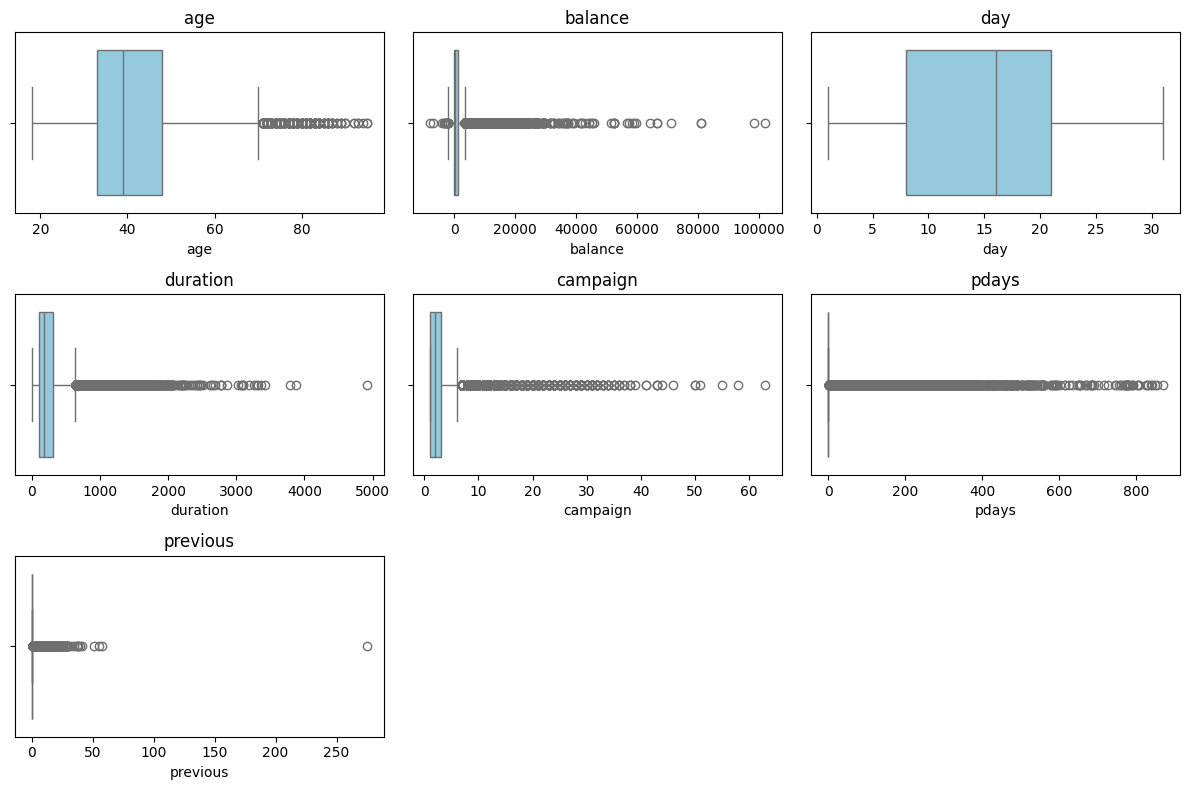

In [7]:
# Box plot
plt.figure(figsize=(12,8))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x = df_train[col], color="skyblue")
    plt.title(f"{col}")
plt.tight_layout()
plt.show()

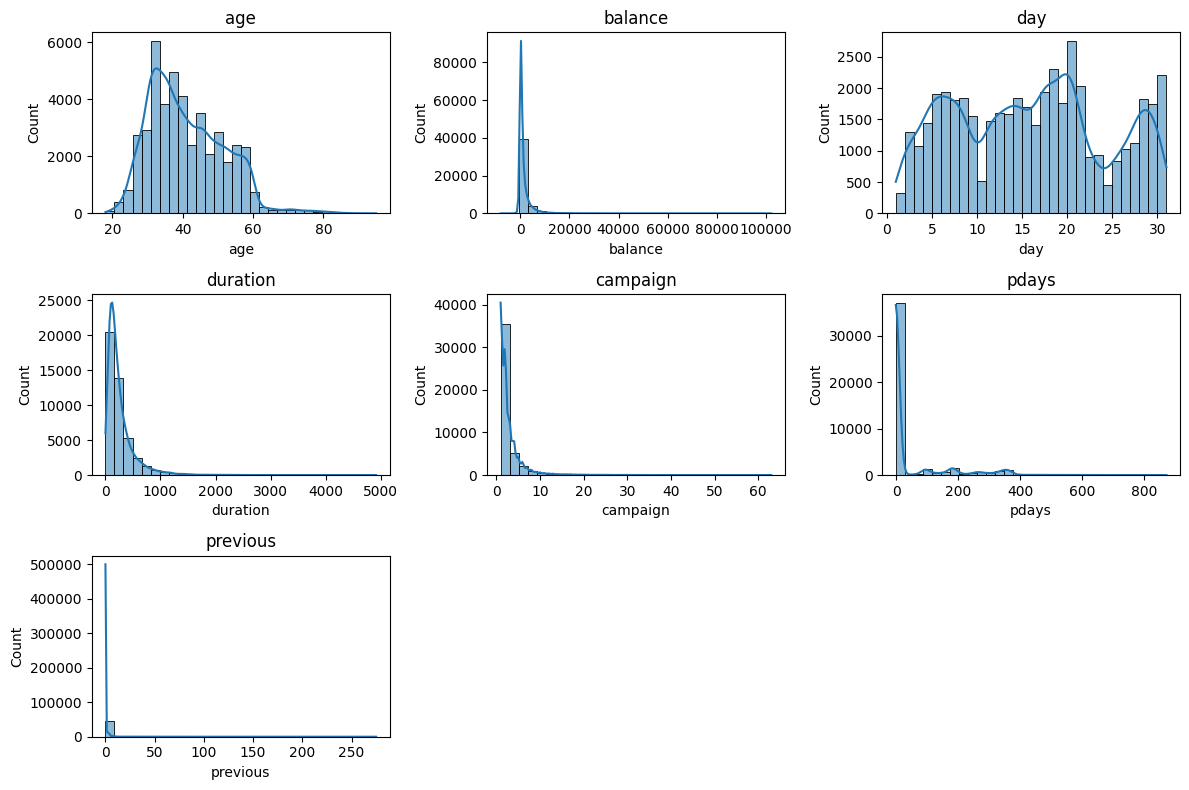

In [8]:
# Distribution
plt.figure(figsize=(12,8))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df_train[col], bins=30, kde=True)
    plt.title(f"{col}")
plt.tight_layout()
plt.show()

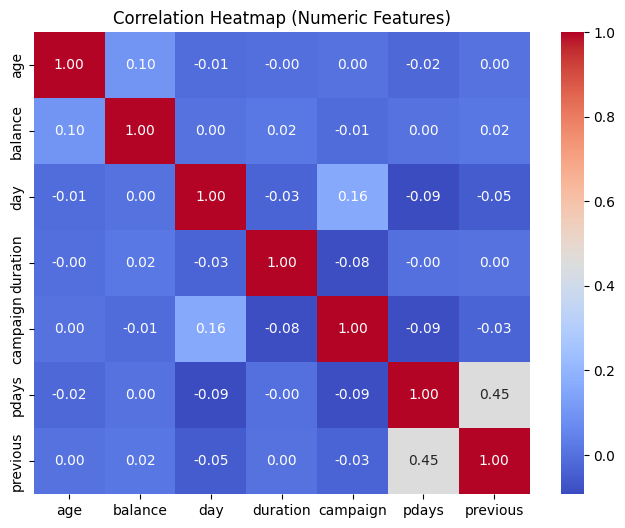

In [9]:
# Correlation
corr = df_train[numeric_cols].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap (Numeric Features)")
plt.show()


We are trying to understand the numerical features in this section:
- How are the features distributed? Do they show any skewness?
- What are the correlations among the features?
- This will help us make better judgments on whether remove outliers, normalize, or remove similar features.

From the box plot and the distribution graphs
- Age       : that looks ok, with outliers
- Balance   : most people fill in 0, maybe people over look this section
- Day       : no outliers, good distribution
- Duration  : dropped due to data leakage
- Campaign  : more than 6 calls during a campain and that would be too many call for one personm > skewed right
- Pdays = contacted_before + pdays_numeric bc -1 means client was not previously contacted, there are too many -1 (81.7%) > skewed right
- Previous  : most clients are new (81.7%) > skewed right

Notes:
- From the correlation heatmap, most features are not correlated to anothers so we can keep them all

Actions
- Age           : StandardScaler
- Balance       : Skewed right with negative values > StandardScaler
- Day           : StandardScaler
- Campaign      : log1p transformed > StandardScaler
- pdays_numeric : log1p transformed > StandardScaler
- previous      : log1p transformed > StandardScaler

What is log1p transform?
- Reduces skewness
- Makes the distribution more normal-like
- Helps with logistic regression

## Categorical features

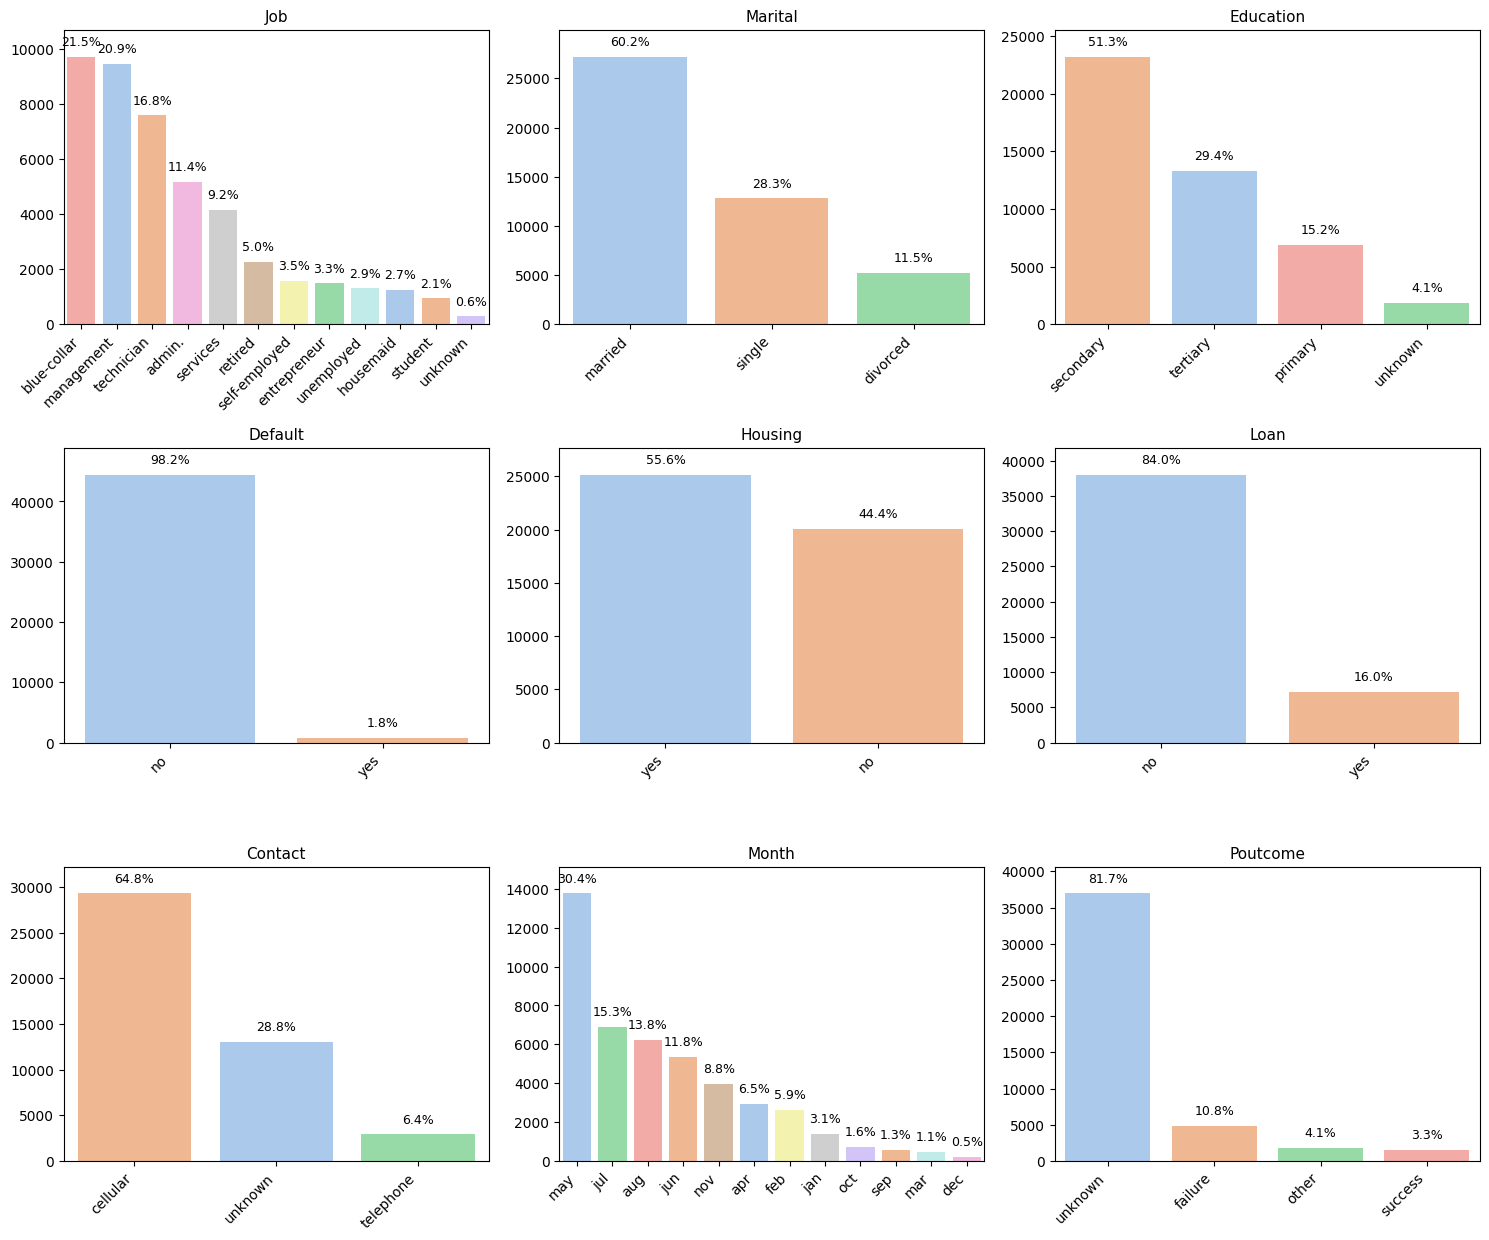

In [10]:
# Graphs
# Number of plots
n     = len(categorical_cols)             # 10
ncols = 3                         # 3 columns
nrows = n // ncols + 1            # 10 // 3 + 1 = 4

plt.figure(figsize=(5*ncols, 4*nrows))

for i, col in enumerate(categorical_cols, 1):
    plt.subplot(nrows, ncols, i)
    ax = sns.countplot(
        x=col,
        hue=col,
        data=df_train,
        palette='pastel',
        order=df_train[col].value_counts().index,
        legend=False
    )

    total = len(df_train)

    # find tallest bar to give extra y-axis space
    max_height = max(p.get_height() for p in ax.patches)
    ax.set_ylim(0, max_height * 1.10)  # 15% space above bars

    # annotate each bar
    for p in ax.patches:
        count = p.get_height()
        percentage = 100 * count / total

        # annotate text slightly above bar top
        ax.annotate(
            f'{percentage:.1f}%',
            xy=(p.get_x() + p.get_width() / 2., p.get_height()),
            xytext=(0, 6),                  # 6 points above the bar
            textcoords='offset points',
            ha='center', va='bottom',
            fontsize=9, color='black'
        )

    plt.title(col.capitalize(), fontsize=11)
    plt.xlabel('')
    plt.ylabel('')
    plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

From the bar charts:
- There are some dominant responses among the features; during training, the classes(freatures) will therefore be weighted.

What is Cramér’s V correlation coefficient?
- It measures the strength of association between two categorical variables.


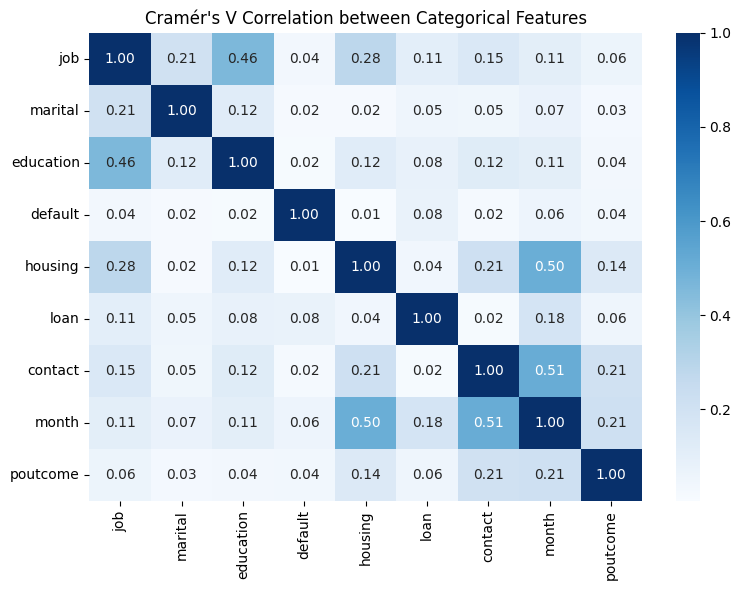

In [11]:
def cramers_v(x, y):
    table = pd.crosstab(x, y)
    chi2  = chi2_contingency(table, correction = False)[0]
    n     = table.sum().sum()
    k     = min(table.shape)
    return np.sqrt(chi2 / (n * (k - 1)))

# build the matrix
cramers = pd.DataFrame(index = categorical_cols, columns=categorical_cols, dtype=float)

for c1 in categorical_cols:
    for c2 in categorical_cols:
        cramers.loc[c1, c2] = cramers_v(df_train[c1], df_train[c2])

# visualize
plt.figure(figsize=(8,6))
sns.heatmap(cramers.astype(float), annot=True, cmap='Blues', fmt=".2f")
plt.title("Cramér's V Correlation between Categorical Features")
plt.tight_layout()
plt.show()


From the Cramer's V heat map
- There is no strong correlation among features
- 0.5 and 0.46 are the two most significant values
- education and job are kind of related - if you are in school > you are a student
- month and housing - in the summer, people are just happy to go buy a house
- month and contact - in the summer, people are just happy to pickup the phone

# **Section 2: Fit models**


In [12]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
    ]
)

In [13]:
def run_cv(model, df: pd.DataFrame, target: str, name: str, cv=5):

    df = df.copy()
    y  = df[target]
    X  = df.drop(columns=[target])

    scoring = {
        "accuracy" : make_scorer(accuracy_score),
        "precision": make_scorer(precision_score),
        "recall"   : make_scorer(recall_score),
        "f1"       : make_scorer(f1_score),
        "auc"      : 'roc_auc',
    }

    # Stratified keeps the class (yes/no) proportions the same in every fold
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)

    cvres = cross_validate(
        model, X, y,
        scoring = scoring,
        cv      = skf,
    )

    return dict(
        Model     = name,
        Accuracy  = cvres["test_accuracy"].mean(),
        Precision = cvres["test_precision"].mean(),
        Recall    = cvres["test_recall"].mean(),
        F1        = cvres["test_f1"].mean(),
        AUC       = cvres["test_auc"].mean(),
    )

In [14]:
models = {
    "Logistic Regression": LogisticRegression(
        class_weight= "balanced",
        max_iter    = 2000,
        solver      = "lbfgs",
    ),
    "Naive Bayes": GaussianNB(),
    "Random Forest": RandomForestClassifier(
        class_weight  = "balanced",
        random_state  = 42,
    ),
    "XGBoost": XGBClassifier(
        scale_pos_weight  = 7.548,
        random_state      = 42,
        eval_metric       = "logloss",
        tree_method       = "hist"
    )
}

In [15]:
df_train.columns = df_train.columns.str.strip()
df_test.columns = df_test.columns.str.strip()

# Data Splitting

In [16]:
# Split into features & labels
X_train = df_train.drop("y", axis=1)
y_train = df_train["y"]

X_test = df_test.drop("y", axis=1)
y_test = df_test["y"]


In [ ]:
results = []

for name, model in models.items():
  pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", model)
  ])
  pipe.fit(X_train, y_train)
  y_pred = pipe.predict(X_test)
  y_pred_proba = pipe.predict_proba(X_test)[:, 1]
  metrics = {
    "Model"   : name,
    "Accuracy": accuracy_score(y_test, y_pred),
    "AUC-ROC" : roc_auc_score(y_test, y_pred_proba),
    "Precision" : precision_score(y_test, y_pred, pos_label=1),
    "Recall" : recall_score(y_test, y_pred, pos_label=1),
    "F1" : f1_score(y_test, y_pred, pos_label=1)
  }
  results.append(metrics)
  # if name in ["Logistic Regression", "Naive Bayes"]:
  #   metrics = run_cv(model, df_L_N_train, 'y', name)
  # else:
  #   metrics = run_cv(model, df_R_X_train, 'y', name)

In [ ]:
# Create comparison table
df_results = pd.DataFrame(results).sort_values(by="F1", ascending=False)
print(df_results)

                 Model  Accuracy   AUC-ROC  Precision    Recall        F1
2        Random Forest  1.000000  1.000000   1.000000  1.000000  1.000000
3              XGBoost  0.905773  0.979266   0.551463  0.976967  0.704986
0  Logistic Regression  0.835656  0.901101   0.394286  0.794626  0.527053
1          Naive Bayes  0.847821  0.792567   0.374436  0.477927  0.419899


# GaussianNB - Hoan Lam

### Load Data

### Helpers

In [ ]:
!pip install pingouin

In [ ]:
# IAMB implementation with partial correlation
# def iamb

# Credited
# https://dev.to/ogambakerubo/feature-selection-with-the-iamb-algorithm-a-casual-dive-into-machine-learning-53a7

import pingouin as pg

def iamb(data, target, alpha=0.05):

  markov_blanket = set()

  # Forward Phase
  for feature in data.columns:
    if feature != target:

      # partial_corr
      # ex:
      #            n         r         CI95%         p-val
      # pearson  768  0.221898  [0.15, 0.29]  5.065127e-10
      #
      # n     - number of valid samples used
      # r     - partial correlations strength
      # CI95% - 95% confidence interval for r
      # p-val - Probability that the observed r occurred by chance if there's no real relationship

      partial_corr  = pg.partial_corr(data=data, x=feature, y=target, covar=markov_blanket)
      p_value       = partial_corr['p-val'].iloc[0]

      # p-value > 0.05 - Could just be randome noise > Ignore feature
      # p-value < 0.05 - Probably meaningful > Keep feature
      if p_value < alpha:
        markov_blanket.add(feature)

  print("Selected Features after Forward Phase :", markov_blanket)

  # Backward Phase
  for feature in list(markov_blanket):
    reduced_mb    = markov_blanket - {feature}
    partial_corr  = pg.partial_corr(data=data, x=feature, y=target, covar=reduced_mb)
    p_value       = partial_corr['p-val'].iloc[0]
    if p_value > alpha:
      markov_blanket.remove(feature)

  print("Selected Features after Backward Phase :", markov_blanket)
  return list(markov_blanket)


# Run cross validation
def run_cv(model, X, y, name: str, cv=5):
  scoring = {
    "accuracy" : make_scorer(accuracy_score),
    "precision": make_scorer(precision_score),
    "recall"   : make_scorer(recall_score),
    "f1"       : make_scorer(f1_score),
    "auc"      : "roc_auc",
  }

  skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)

  cvres = cross_validate(
    model, X, y,
    scoring = scoring,
    cv      = skf,
  )

  return dict(
    Model     = name,
    Accuracy  = cvres["test_accuracy"].mean(),
    Precision = cvres["test_precision"].mean(),
    Recall    = cvres["test_recall"].mean(),
    F1        = cvres["test_f1"].mean(),
    AUC       = cvres["test_auc"].mean(),
  )

### Apply IAMB

In [ ]:
selected_features = iamb(df_L_N_train, 'y', alpha=0.05)

NameError: name 'df_L_N_train' is not defined

In [ ]:
new_df_L_N_train = df_L_N_train[selected_features].assign(y=df_L_N_train['y'])

NameError: name 'df_L_N_train' is not defined

In [ ]:
# IAMB results - 49 features > 28 features

In [ ]:
display(df_L_N_train.shape)
df_L_N_train.head()

NameError: name 'df_L_N_train' is not defined

In [ ]:
display(new_df_L_N_train.shape)
new_df_L_N_train.head()

NameError: name 'new_df_L_N_train' is not defined

### Checking if test.csv a subset of train.csv - It is sadly

In [ ]:
train = pd.read_csv("train.csv")
test  = pd.read_csv("test.csv")

FileNotFoundError: [Errno 2] No such file or directory: 'train.csv'

In [ ]:
is_subset = test.merge(train.drop_duplicates(), how="left", indicator=True)["_merge"].eq("both").all()
print("Test ⊆ Train ?", is_subset)

Test ⊆ Train ? True


### Since test.csv is a subset of train.csv > going to split the training into training and testing

In [ ]:
from sklearn.model_selection import train_test_split

# Split data
X = df_L_N_train.drop('y', axis=1)
y = df_L_N_train['y']

X_train, X_test, y_train, y_test = train_test_split(
  X, y,
  test_size=0.3,
  random_state=42,
  stratify=y          # this ensures the class proportion in train and test matches the original
)

X_train_selected  = X_train[selected_features]
X_test_selected   = X_test[selected_features]

### GaussianNB Models

In [ ]:
gnb_1 = GaussianNB()  # ALl features
gnb_2 = GaussianNB()  # Selected features

### Cross validation to average results

In [ ]:
results = []
for name, model in [
  ("Naive Bayes", gnb_1),
  ("Naive Bayes IAMB", gnb_2),

]:
  if name in ["Naive Bayes"]:
    metrics = run_cv(model, X_train, y_train, name)
  else:
    metrics = run_cv(model, X_train_selected, y_train, name)
  results.append(metrics)

# Create comparison table
df_results = pd.DataFrame(results).sort_values(by="F1", ascending=False)
print(df_results)

              Model  Accuracy  Precision    Recall        F1       AUC
0       Naive Bayes  0.826808   0.324785  0.445961  0.375602  0.735862
1  Naive Bayes IAMB  0.826619   0.311553  0.398693  0.349633  0.727091


### Models to test on the test set

In [ ]:
from sklearn.metrics import roc_auc_score

# Model with All Features
model_all   = gnb_1
model_all.fit(X_train, y_train)
y_pred_all  = model_all.predict(X_test)

# Model with IAMB-Selected Features
model_iamb  = gnb_2
model_iamb.fit(X_train_selected, y_train)
y_pred_iamb = model_iamb.predict(X_test_selected)

# Evaluate models
results = {
  'Model'   : ['Naive Bayes', 'Naive Bayes IAMB'],
  'Accuracy': [accuracy_score(y_test, y_pred_all), accuracy_score(y_test, y_pred_iamb)],
  'F1 Score': [f1_score(y_test, y_pred_all), f1_score(y_test, y_pred_iamb)],
  'AUC-ROC' : [roc_auc_score(y_test, model_all.predict_proba(X_test)[:, 1]), roc_auc_score(y_test, model_iamb.predict_proba(X_test_selected)[:, 1]),]
}

results_df = pd.DataFrame(results)
print(results_df)

              Model  Accuracy  F1 Score   AUC-ROC
0       Naive Bayes  0.828517  0.382369  0.740632
1  Naive Bayes IAMB  0.830139  0.361419  0.736056


**RANDOM FOREST ALGORITHM-SANKEERTHANA**


*   **INSPECT TARGET VARIABLE**







In [36]:
print("\n STEP 2: Inspecting target variable 'y'...")

print(f"\n   Train 'y' before conversion:")
print(f"   - Data type: {df_train['y'].dtype}")
print(f"   - Unique values: {df_train['y'].unique()}")
print(f"   - Value counts:\n{df_train['y'].value_counts()}")

print(f"\n   Test 'y' before conversion:")
print(f"   - Data type: {df_test['y'].dtype}")
print(f"   - Unique values: {df_test['y'].unique()}")
print(f"   - Value counts:\n{df_test['y'].value_counts()}")




 STEP 2: Inspecting target variable 'y'...

   Train 'y' before conversion:
   - Data type: object
   - Unique values: ['no' 'yes']
   - Value counts:
y
no     39922
yes     5289
Name: count, dtype: int64

   Test 'y' before conversion:
   - Data type: object
   - Unique values: ['no' 'yes']
   - Value counts:
y
no     4000
yes     521
Name: count, dtype: int64


**CONVERT TARGET VARIABLE (WITH VERIFICATION)**


In [37]:
print("\n STEP 3: Converting target variable...")

# Method 1: Using map (most reliable)
print("\n   Attempting conversion using .map()...")
df_train['y'] = df_train['y'].map({'yes': 1, 'no': 0})
df_test['y'] = df_test['y'].map({'yes': 1, 'no': 0})

print(f"\n   Train 'y' after conversion:")
print(f"   - Data type: {df_train['y'].dtype}")
print(f"   - Unique values: {df_train['y'].unique()}")
print(f"   - Value counts:\n{df_train['y'].value_counts()}")
print(f"   - Any NaN values? {df_train['y'].isna().sum()}")

print(f"\n   Test 'y' after conversion:")
print(f"   - Data type: {df_test['y'].dtype}")
print(f"   - Unique values: {df_test['y'].unique()}")
print(f"   - Value counts:\n{df_test['y'].value_counts()}")
print(f"   - Any NaN values? {df_test['y'].isna().sum()}")

# Check if conversion worked
if df_train['y'].isna().any():
    print("\n  WARNING: Some values couldn't be converted! Trying alternative method...")
    df_train = pd.read_csv("https://raw.githubusercontent.com/GVSU-CIS635/projects-team-1-1/main/data/train.csv", sep=";")
    df_test = pd.read_csv("https://raw.githubusercontent.com/GVSU-CIS635/projects-team-1-1/main/data/test.csv", sep=";")
    df_train.columns = df_train.columns.str.strip()
    df_test.columns = df_test.columns.str.strip()

    # Method 2: Using replace
    df_train['y'] = df_train['y'].replace({'yes': 1, 'no': 0})
    df_test['y'] = df_test['y'].replace({'yes': 1, 'no': 0})

    print(f"   After alternative method:")
    print(f"   Train y: {df_train['y'].value_counts()}")
    print(f"   Test y: {df_test['y'].value_counts()}")




 STEP 3: Converting target variable...

   Attempting conversion using .map()...

   Train 'y' after conversion:
   - Data type: int64
   - Unique values: [0 1]
   - Value counts:
y
0    39922
1     5289
Name: count, dtype: int64
   - Any NaN values? 0

   Test 'y' after conversion:
   - Data type: int64
   - Unique values: [0 1]
   - Value counts:
y
0    4000
1     521
Name: count, dtype: int64
   - Any NaN values? 0


**FEATURE PREPARATION**








In [38]:
# Define numeric and categorical columns
numeric_cols = df_train.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_cols = df_train.select_dtypes(include=["object"]).columns.tolist()

# Remove target from lists if present
if "y" in numeric_cols:
    numeric_cols.remove("y")
if "y" in categorical_cols:
    categorical_cols.remove("y")

print(f"\nNumeric features ({len(numeric_cols)}): {numeric_cols}")
print(f"Categorical features ({len(categorical_cols)}): {categorical_cols}")

# Split features and target
X_train = df_train.drop("y", axis=1)
y_train = df_train["y"]
X_test = df_test.drop("y", axis=1)
y_test = df_test["y"]
print(f"\n   Data split verification:")
print(f"   • X_train shape: {X_train.shape}")
print(f"   • y_train shape: {y_train.shape}, dtype: {y_train.dtype}")
print(f"   • X_test shape: {X_test.shape}")
print(f"   • y_test shape: {y_test.shape}, dtype: {y_test.dtype}")

print(f"\n   Class distribution in y_train:")
if y_train.dtype in ['int64', 'int32', 'float64']:
    class_0 = (y_train == 0).sum()
    class_1 = (y_train == 1).sum()
    print(f"   • No (0):  {class_0:,} ({class_0/len(y_train)*100:.1f}%)")
    print(f"   • Yes (1): {class_1:,} ({class_1/len(y_train)*100:.1f}%)")
else:
    print(f"    ERROR: y_train is not numeric! Type: {y_train.dtype}")
    print(f"   Values: {y_train.unique()}")

print(f"\n   Class distribution in y_test:")
if y_test.dtype in ['int64', 'int32', 'float64']:
    test_class_0 = (y_test == 0).sum()
    test_class_1 = (y_test == 1).sum()
    print(f"   • No (0):  {test_class_0:,} ({test_class_0/len(y_test)*100:.1f}%)")
    print(f"   • Yes (1): {test_class_1:,} ({test_class_1/len(y_test)*100:.1f}%)")
else:
    print(f"    ERROR: y_test is not numeric! Type: {y_test.dtype}")
    print(f"   Values: {y_test.unique()}")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_cols),
    ]
)





Numeric features (7): ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
Categorical features (9): ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']

   Data split verification:
   • X_train shape: (45211, 16)
   • y_train shape: (45211,), dtype: int64
   • X_test shape: (4521, 16)
   • y_test shape: (4521,), dtype: int64

   Class distribution in y_train:
   • No (0):  39,922 (88.3%)
   • Yes (1): 5,289 (11.7%)

   Class distribution in y_test:
   • No (0):  4,000 (88.5%)
   • Yes (1): 521 (11.5%)


**PREPROCESSING PIPELINE**



In [18]:
# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_cols),
    ]
)


 **RANDOM FOREST MODEL (TRAINING PHASE)**


In [46]:
print("\n" + "=" * 80)
print(" STEP 5: TRAINING RANDOM FOREST")
print("=" * 80)

rf_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(
        n_estimators=200,
        max_depth=20,
        min_samples_split=5,
        min_samples_leaf=2,
        max_features='sqrt',
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    ))
])

print("\n Training...")
start_train = time.time()
rf_model.fit(X_train, y_train)
train_time = time.time() - start_train
print(f"Training complete in {train_time:.1f} seconds!")




 STEP 5: TRAINING RANDOM FOREST

 Training...
Training complete in 13.1 seconds!


**Prediction**

****

In [41]:

print("\n" + "=" * 80)
print(" STEP 6: MAKING PREDICTIONS")
print("=" * 80)

print("\nGenerating predictions...")
y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]

print(f"\n Prediction verification:")
print(f"   • y_pred shape: {y_pred.shape}")
print(f"   • y_pred dtype: {y_pred.dtype}")
print(f"   • y_pred unique values: {np.unique(y_pred)}")
print(f"   • y_pred_proba shape: {y_pred_proba.shape}")
print(f"   • y_pred_proba range: [{y_pred_proba.min():.4f}, {y_pred_proba.max():.4f}]")

predicted_yes = (y_pred == 1).sum()
predicted_no = (y_pred == 0).sum()
actual_yes = (y_test == 1).sum()
actual_no = (y_test == 0).sum()

print(f"\n PREDICTION RESULTS:")
print(f"   Predicted YES: {predicted_yes:4d} ({predicted_yes/len(y_test)*100:.1f}%)")
print(f"   Predicted NO:  {predicted_no:4d} ({predicted_no/len(y_test)*100:.1f}%)")
print(f"\n   Actual YES:    {actual_yes:4d} ({actual_yes/len(y_test)*100:.1f}%)")
print(f"   Actual NO:     {actual_no:4d} ({actual_no/len(y_test)*100:.1f}%)")

# Show sample predictions
print(f"\n Sample predictions (first 10):")
sample_df = pd.DataFrame({
    'Predicted': y_pred[:10],
    'Probability': y_pred_proba[:10],
    'Actual': y_test.values[:10]
})
print(sample_df.to_string(index=False))




 STEP 6: MAKING PREDICTIONS

Generating predictions...

 Prediction verification:
   • y_pred shape: (4521,)
   • y_pred dtype: int64
   • y_pred unique values: [0 1]
   • y_pred_proba shape: (4521,)
   • y_pred_proba range: [0.0002, 0.9874]

 PREDICTION RESULTS:
   Predicted YES:  728 (16.1%)
   Predicted NO:  3793 (83.9%)

   Actual YES:     521 (11.5%)
   Actual NO:     4000 (88.5%)

 Sample predictions (first 10):
 Predicted  Probability  Actual
         0     0.139694       0
         0     0.065428       0
         0     0.120400       0
         0     0.029802       0
         0     0.019337       0
         0     0.430183       0
         0     0.131637       0
         0     0.033404       0
         0     0.006313       0
         0     0.077262       0


This model can predict the new data

**CALCULATE METRICS (ONLY IF DATA IS VALID)**

In [45]:
print("\n" + "=" * 80)
print(" STEP 7: PERFORMANCE METRICS")
print("=" * 80)

if predicted_yes > 0 or predicted_no > 0:
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    auc_roc = roc_auc_score(y_test, y_pred_proba)

    print(f"\n Final Results:")
    print("=" * 60)
    print(f"   Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"   Precision: {precision:.4f}")
    print(f"   Recall:    {recall:.4f}")
    print(f"   F1-Score:  {f1:.4f}")
    print(f"   AUC-ROC:   {auc_roc:.4f}")
    print("=" * 60)

    print(f"\n Classification Report:")
    print(classification_report(y_test, y_pred, target_names=['No', 'Yes'], zero_division=0))

    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    print(f"\n Confusion Matrix:")
    print(f"   True Negatives:  {tn:4d}")
    print(f"   False Positives: {fp:4d}")
    print(f"   False Negatives: {fn:4d}")
    print(f"   True Positives:  {tp:4d}")

    # Comparison table
    print("\n" + "=" * 80)
    print(" FOR TEAM COMPARISON")
    print("=" * 80)

    results_df = pd.DataFrame([{
        "Model": "Random Forest",
        "Accuracy": f"{accuracy:.4f}",
        "Precision": f"{precision:.4f}",
        "Recall": f"{recall:.4f}",
        "F1": f"{f1:.4f}",
        "AUC-ROC": f"{auc_roc:.4f}"
    }])

    print("\n" + results_df.to_string(index=False))

else:
    print("\n ERROR: No predictions were made!")
    print("   This means the data wasn't loaded or converted correctly.")
    print("   Please check the debug information above.")




 STEP 7: PERFORMANCE METRICS

 Final Results:
   Accuracy:  0.9445 (94.45%)
   Precision: 0.6854
   Recall:    0.9578
   F1-Score:  0.7990
   AUC-ROC:   0.9916

 Classification Report:
              precision    recall  f1-score   support

          No       0.99      0.94      0.97      4000
         Yes       0.69      0.96      0.80       521

    accuracy                           0.94      4521
   macro avg       0.84      0.95      0.88      4521
weighted avg       0.96      0.94      0.95      4521


 Confusion Matrix:
   True Negatives:  3771
   False Positives:  229
   False Negatives:   22
   True Positives:   499

 FOR TEAM COMPARISON

        Model Accuracy Precision Recall     F1 AUC-ROC
Random Forest   0.9445    0.6854 0.9578 0.7990  0.9916
